![img](./images/SplashHeader.jpg)

# Modeling housing price data in King County:  An inferential and predictive analysis

## Business Understanding


Our chosen stakeholder is the real-estate agency Keller Williams, who's looking to expand into King County in Washington. They want an analytically supported strategy based on inferential and predictive analysis of the data available on the king county website. Our approach to formulating the business question was to first define our recommended strategy and formulate the business question around it. Accordingly, we formulated three questions that we wanted to answer using our data analysis and based our recommendations on those questions. 

### Recommended strategy 

We defined our strategy based on the volume metrics of the data and determined that the best way moving forward is to target sellers and buyers of houses that are in highest demand. We chose this strategy because we felt this approach would maximize your future potential revenue. This is based on the notion that a higher quantity of sales would result in more revenues than higher-value sales. 

### Business Question

Given our recommended strategy, the business question we formulated is :What types of houses are in most demand and where are they located?

## Data Understanding


The data that we used originally came from the King County website. It contains a good mix of categorical and numerical data. We wanted to focus on variables that corresponded to features that determine that demand of the any given house. 

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
from matplotlib import ticker
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm
from statsmodels.api import OLS

# SciKitLearn 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# For mapping visuals
import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)

The libraries that we have imported are libraries that we used throughout this project, in data preparation and modeling sections.

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


The table above illustrates the raw data set and how its formatted, while the table below lists all the columns in the data set and what data type the information in that column is. Furthermore, it also gives us an initial idea of the proportion of missing (null) values there are in each column. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Data Preparation


Our approach to data preparation was systematic. First we dropped columns that that didn't have enough data to incorporate into our model and we also removed some extraneous outliers

#### Drops

We dropped the variable 'yr_renovated' because it was missing values for about 70% of our dataset. Furthermore, we dropped the variables 'id' and 'date' because we felt that those variables will be less reliable predictors. We also dropped an outlier from our data set; a house with 33 bedrooms. We also created a bedrooms bin column to use ahead.

In [4]:
df = df[df['bedrooms'] != 33]

In [5]:
#Making a categorical bedroom columns
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins = [0,1,2,3,4,5,6,99], labels=['1BR','2BR','3BR','4BR','5BR','6BR','7+BR'])

In [6]:
df = df.drop(['id', 'date', 'yr_renovated','sqft_basement'], axis=1) 

#### Removing Outliers

When looking at removing outliers from our data set, we first used the numpy library to calculate our quantiles to determine which rows are the outliers. Based on the values we calculated for two numerical variables : 'price' and 'sqft_lot', we removed the corresponding rows. Furthermore, for the categorical variable 'grade' we performed the value_counts method in pandas to determine the counts of houses for each grade. Since the grades '3 Poor' and '12 Luxury' only have one record each, we excluded those values from our final processing data set as well.

In [7]:
price_q75, price_q25 = np.percentile(df['price'],[75,25])
intr_qrt = price_q75-price_q25
upper_price = price_q75 + (1.5*intr_qrt)
lower_price = price_q25 - (1.5*intr_qrt)
lower_price, upper_price
df = df[df['price'] <= upper_price]
df = df[df['price'] >= lower_price]

In [8]:
df['sqft_lot'].describe()

count    2.043800e+04
mean     1.458599e+04
std      4.001076e+04
min      5.200000e+02
25%      5.000000e+03
50%      7.500000e+03
75%      1.031675e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [9]:
sqft_lot_q75, sqft_lot_q25 = np.percentile(df['sqft_lot'],[75,25])
intr_qrt = sqft_lot_q75-sqft_lot_q25
upper_sqft_lot = sqft_lot_q75 + (1.5*intr_qrt)
lower_sqft_lot = sqft_lot_q25 - (1.5*intr_qrt)
lower_sqft_lot, upper_sqft_lot
df = df[df['sqft_lot'] <= upper_sqft_lot]
df = df[df['sqft_lot'] >= lower_sqft_lot]

In [10]:
df['grade'].value_counts()

7 Average        8371
8 Good           5297
6 Low Average    1872
9 Better         1866
10 Very Good      513
5 Fair            198
11 Excellent       75
4 Low              20
12 Luxury           1
3 Poor              1
Name: grade, dtype: int64

In [11]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '12 Luxury']

### Helper Functions

These are a list of helper functions that we created to help us streamline our work flow and minimize repeating code 

In [12]:
def ohe(df, df2, column):    
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop="first", sparse=False, handle_unknown="error")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train,
                                     columns=col_names, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, 
                                    columns=col_names, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
    return df, df2, encoded_train.columns.tolist()

The function above creates a pipeline to perform two different transformations to test or train? data for any given input variable: First it utilizes the OneHotEncoder to take our categorical variables and encode them into a form that we can use in linear regression. The function takes in a training df, 'df', a test df, 'df2', and a column name, ['column_name']. It returns the training df and the test df concatenated with the new encoded columns. It also returns a list of the new encoded column names.  Secondly, it runs linear regression on encoded values by using .fit().

In [13]:
def scale_n_score(x,y,x2,y2):        
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)

    print('Training Score:',r2_score(y_train,train_preds))
    print('Test Score:',r2_score(y_test,test_preds))
    return X_train_scaled, X_test_scaled, train_preds, test_preds

The function above performs two actions; first it runs Standard Scaler, which scales all the values, in the test data and training data respectively, so that the output of our models are depicted in comparable units. Secondly, it scores the scaled data to get the R^2 results, a metric used in determining the efficacy of our model. 

In [14]:
def get_train_test_metrics(y_train,train_preds,
               y_test,test_preds
              ):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

The function above uses the inputs of price and the predictions from our model to dtermine Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for both the training and the testing data sets. Comparison of these values allow us to see how our model has performed. 

### The Train-Test Split

We set price as a dependent/target variable and every other variable in our data set as the independent/predictor variables. Then we performed a train/test split on the data. This will allow us to see the true performance of our model because we will be fitting our linear regression to our training data and then applying it to our testing data. The purpose of this is to treat the testing data as unseen data (data that our model hasn't experienced yet) and by comparing the training metrics between these two-data sets we can gain a better understanding of the validity of each model we create in the iterative process. 

In [15]:
y = df["price"]
X = df.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

### Categorical Variables


The variables : 'bedroom_bin', 'view', 'zipcode', 'condition', and 'grade' are categorical variables. While the variables 'waterfront' is a binomial categorical variable. Each of these variables need to be converted into a format that can be modeled. 

#### Waterfront

Since this variable is a binomial categorical variable, OridinalEncoder was used to change this variable into a numeric one. Values denoted with "NAs" were determined to be "No" so those values were replaced as such.  

In [16]:
X_train['waterfront'].fillna('NO', inplace=True)
X_test['waterfront'].fillna('NO', inplace=True)

In [17]:
waterfront_train = X_train[['waterfront']]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]
waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()
X_train["waterfront"] = waterfront_encoded_train

In [18]:
waterfront_test = X_test[['waterfront']]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_test.flatten()
X_test["waterfront"] = waterfront_encoded_test

#### View 

The variable 'view' has 5 categories; NONE, AVERAGE, GOOD, FAIR, and EXCELLENT. The helper function we created above was use to encode this variable into a numeric one. We also replaced the string values so we could use it for comparative analysis to make our modeling process more efficient

In [19]:
X_train['view'].isna().sum()

45

In [20]:
X_train['view'].fillna("NONE", inplace=True)
X_test['view'].fillna("NONE", inplace=True)

In [21]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [22]:
# Change view rating to a numeric value for comparative purposes.
X_train['view'] = X_train['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'AVERAGE':3,
                             'FAIR':2,
                             'NONE':1})

In [23]:
X_test['view'] = X_test['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'AVERAGE':3,
                             'FAIR':2,
                             'NONE':1})

#### Condition 

We again replaced the string values in this column and the utilized the ohe function to perform the same encoding as above.

In [24]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [25]:
# Change condition rating to a numeric value for comparitive purposes.
X_train['condition'] = X_train['condition'].map({'Very Good':5,
                                       'Good':4,
                                       'Average':3,
                                       'Fair':2,
                                       'Poor':1})

In [26]:
X_test['condition'] = X_test['condition'].map({'Very Good':5,
                                       'Good':4,
                                       'Average':3,
                                       'Fair':2,
                                       'Poor':1})

Similarly, the ohe() function was used below to encode the remaining categorical variables : 'grade', 'zipcode' and 'bedroom_bins'

#### Grade 

In [27]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

#### Zipcode 

In [28]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

#### Bedroom_bins

In [29]:
X_train, X_test, encoded_bedroom_bin = ohe(X_train, X_test, ['bedrooms_bin'])

We treated the 'bedroom' variable as a categorical variable even though its a numeric variable because we found that in the raw data, bigger homes skewed our model. We found that by treating it as a categorical variable improved model performance and accounted for the lack of data in the higher range of bedrooms without any data loss. 

## Our iterative modeling process


First, we created a dummy regressor to act as our baseline model, our scores indicate that our model is performing better than the base model

#### Base Model - Dummy Regressor

In [30]:
dummy = DummyRegressor() #mean strategy
dummy.fit(X_train,y_train)
dummy.score(X_train,y_train)

0.0

In [31]:
dummy.score(X_test,y_test)

-0.0002287894919794642

#### Model 1

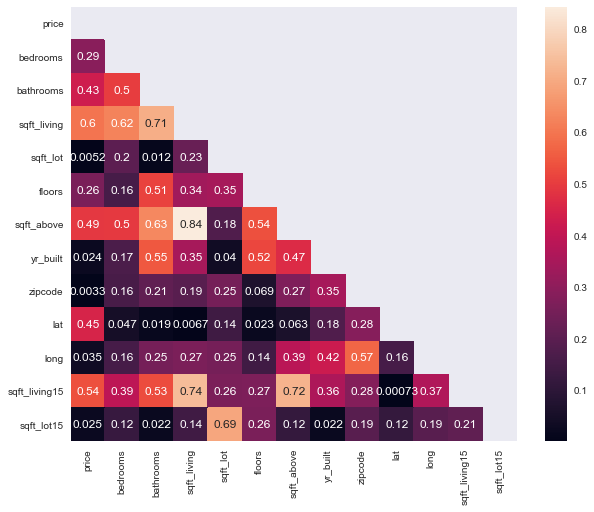

In [32]:
# sns.heatmap(df.corr(),annot=True)
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(10, 8))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    f.savefig('images/Corelation Heatmap',bbox_inches="tight")

Our first model only uses 'sqft_living' as a predictor for our target because it was the most correlated variable to price as depicted by the seaborn heatmap above. We used our scale_n_score helper function to get the r^2 scores for each model. 

In [33]:
cols = ['sqft_living']
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [34]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.35205094281398364
Test Score: 0.3790093814962543


The r^2 values here determine that Model 1 only accounts for roughly 35-40% of the variance of house prices in King County. On the contrary, our model did perform well because the scores between the training and test set aren't that different. Finally,a higher r^2 value for the test data compared to the training data, in this case,this could indicate that model 1 is too simple.

#### Model 2
We first chose to use columns 'sqft_living', 'sqft_living15', 'bathrooms', and the columns created from encoding 'zipcode'.

In [35]:
df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.598983
sqft_living15    0.536502
sqft_above       0.492556
lat              0.450100
bathrooms        0.429260
bedrooms         0.292722
floors           0.262999
long             0.034681
sqft_lot15       0.024641
yr_built         0.024433
sqft_lot         0.005248
zipcode          0.003252
Name: price, dtype: float64

In [36]:
cols = ['sqft_living', 'bathrooms', 'sqft_living15'] +  encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)


In [37]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.7972171842793818
Test Score: 0.8086365897018465


In [38]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.797
Mean Absolute Error: 67121.184
Mean Squared Error: 8476942207.650
Root Mean Squared Error: 92070.311

Testing Metrics:
R2: 0.809
Mean Absolute Error: 65392.585
Mean Squared Error: 7888959233.643
Root Mean Squared Error: 88819.813


#### Model 2b
This model uses the columns 'sqft_living', 'bathrooms', 'sqft_living15', and 'zipcode'. 

In [39]:
cols = ['sqft_living', 'bathrooms', 'sqft_living15', 'zipcode']
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [40]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.3993413028686136
Test Score: 0.4109408603232637


In [41]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.399
Mean Absolute Error: 127074.905
Mean Squared Error: 25109371541.226
Root Mean Squared Error: 158459.369

Testing Metrics:
R2: 0.411
Mean Absolute Error: 125592.315
Mean Squared Error: 24283971172.305
Root Mean Squared Error: 155833.152


Note the difference between entering the encoded columns for 'zipcode' and actually entering the column 'zipcode'. The encoding gives us a higher R2 value and gives us a lower Root Mean Squared Error. Using encoded categorical variables seems to improve our models.

#### Model 3
Using columns  'sqft_living', 'bedrooms', 'sqft_living15', and the columns created from encoding 'zipcode'.

In [42]:
cols = ['sqft_living', 'bedrooms', 'sqft_living15'] +  encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [43]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.7978039612711763
Test Score: 0.8092911549828725


In [44]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.798
Mean Absolute Error: 67040.807
Mean Squared Error: 8452413133.869
Root Mean Squared Error: 91937.006

Testing Metrics:
R2: 0.809
Mean Absolute Error: 65267.174
Mean Squared Error: 7861974770.888
Root Mean Squared Error: 88667.778


##### Model 3b

Trying model 3 with encoded_bathrooms_bin.

In [45]:
cols = ['sqft_living', 'sqft_living15'] +  encoded_zipcode + encoded_bedroom_bin
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [46]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.799227552045403
Test Score: 0.8114168190412745


In [47]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.799
Mean Absolute Error: 66764.908
Mean Squared Error: 8392902683.353
Root Mean Squared Error: 91612.787

Testing Metrics:
R2: 0.811
Mean Absolute Error: 64862.175
Mean Squared Error: 7774344240.710
Root Mean Squared Error: 88172.242


The R2 values from model 3 are acceptable. I would like to minimize the RMSE values as much as possible. 

#### Model 4
Using columns 'sqft_living', 'bedrooms', and the columns created from encoding 'zipcode' and 'condition'.

In [48]:
cols = ['sqft_living', 'bedrooms'] +  encoded_zipcode + encoded_condition
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [49]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.7882553234618938
Test Score: 0.8019139401688503


In [50]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.788
Mean Absolute Error: 68359.691
Mean Squared Error: 8851575412.899
Root Mean Squared Error: 94082.811

Testing Metrics:
R2: 0.802
Mean Absolute Error: 65715.248
Mean Squared Error: 8166100553.528
Root Mean Squared Error: 90366.479


#### Model 4b
Using columns 'sqft_living', and the columns created from encoding 'zipcode', 'bedroom_bin', and 'condition'.

In [51]:
cols = ['sqft_living']  + encoded_bedroom_bin +  encoded_zipcode + encoded_condition
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [52]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.7899254758710148
Test Score: 0.8043563330303309


In [53]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.790
Mean Absolute Error: 68112.963
Mean Squared Error: 8781757931.572
Root Mean Squared Error: 93711.034

Testing Metrics:
R2: 0.804
Mean Absolute Error: 65248.085
Mean Squared Error: 8065412874.067
Root Mean Squared Error: 89807.644


Again the R2 values from model 4 are acceptable, but I would like to minimize the RMSE values as much as possible. 

#### Model 5
Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'condition', 'view', and the columns created from encoding 'zipcode'. 

In [54]:
cols = ['sqft_living', 'bedrooms', 'bathrooms', 'condition', 'view'] +  encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [55]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.8040314404358433
Test Score: 0.8109625646254899


In [56]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.804
Mean Absolute Error: 66343.096
Mean Squared Error: 8192085448.850
Root Mean Squared Error: 90510.140

Testing Metrics:
R2: 0.811
Mean Absolute Error: 64588.874
Mean Squared Error: 7793070885.277
Root Mean Squared Error: 88278.372


#### Model 5b
Compared to encoded bedroom_bin, view, and condition.

In [57]:
cols = ['sqft_living', 'bathrooms'] + encoded_bedroom_bin + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [58]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.8073561781701597
Test Score: 0.8144964137689303


In [59]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.807
Mean Absolute Error: 65794.564
Mean Squared Error: 8053101237.938
Root Mean Squared Error: 89739.073

Testing Metrics:
R2: 0.814
Mean Absolute Error: 63897.108
Mean Squared Error: 7647387905.511
Root Mean Squared Error: 87449.345


Getting warmer. 

#### Model 6

In this model the predictor variables we used were 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the ectra columns created from encoding the categorical variables: 'condition', 'view', and 'zipcode'. We did not use 'grade' in this model as we determine that 'condition' was an equivalent indicator.

In [60]:
cols = ['sqft_living', 'bedrooms', 'bathrooms', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [61]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.805909058601276
Test Score: 0.8118721210013764


The r^2 score value shown above depicts that Model accounts for about 80% of the variance of house price in our dataset. This indicates that model is performing inferential analysis much better than model 1. Furthermore, the test score is even higher than the Training score which indicates that the predictive performance of the model is also great.

In [62]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.806
Mean Absolute Error: 66048.354
Mean Squared Error: 8113595264.069
Root Mean Squared Error: 90075.498

Testing Metrics:
R2: 0.812
Mean Absolute Error: 64411.926
Mean Squared Error: 7755574411.114
Root Mean Squared Error: 88065.739


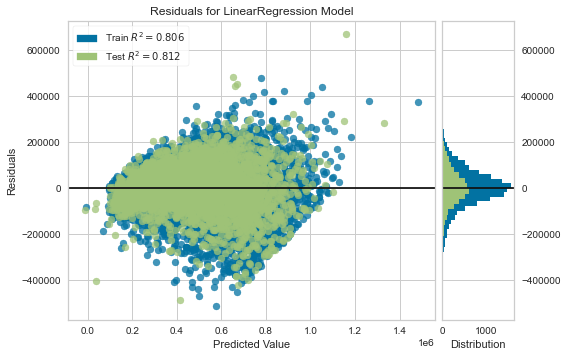

In [63]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

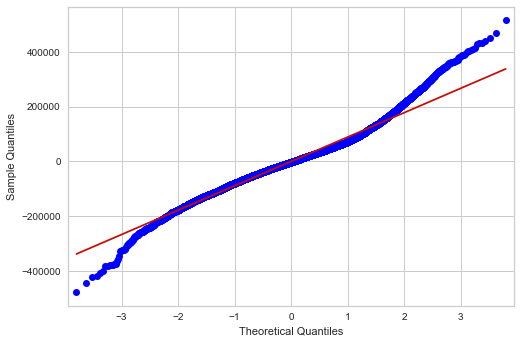

In [64]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

#### Model 6b

In [65]:
cols = ['sqft_living', 'bathrooms', 'yr_built'] + encoded_bedroom_bin + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [66]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.8078044199599432
Test Score: 0.8143669163699321


In [67]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.808
Mean Absolute Error: 65731.199
Mean Squared Error: 8034363359.516
Root Mean Squared Error: 89634.610

Testing Metrics:
R2: 0.814
Mean Absolute Error: 63962.932
Mean Squared Error: 7652726437.574
Root Mean Squared Error: 87479.863


#### Model 7

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the columns created from encoding 'condition', 'view', and 'zipcode'. 

In [68]:
cols = ['sqft_living', 'sqft_living15', 'bedrooms', 'bathrooms', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [69]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.8162984121309026
Test Score: 0.8209083160697839


In [70]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.816
Mean Absolute Error: 64187.454
Mean Squared Error: 7679288495.359
Root Mean Squared Error: 87631.550

Testing Metrics:
R2: 0.821
Mean Absolute Error: 63030.485
Mean Squared Error: 7383057144.564
Root Mean Squared Error: 85924.718


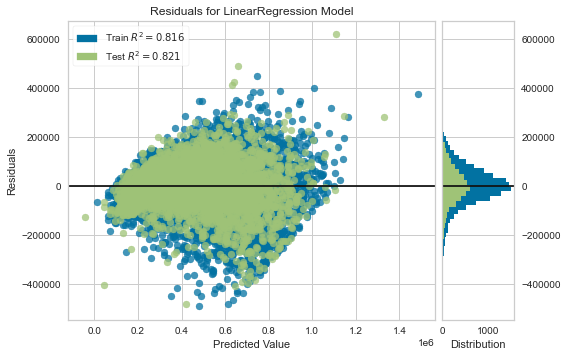

In [71]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

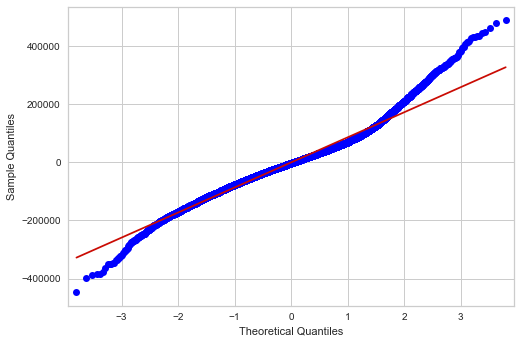

In [72]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

#### Model 7b

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the columns created from encoding 'bedroom_bin', 'condition', 'view', and 'zipcode'.

In [73]:
cols = ['sqft_living', 'sqft_living15', 'bathrooms', 'yr_built'] + encoded_bedroom_bin + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [74]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.8177610258953996
Test Score: 0.822780574427596


In [75]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.818
Mean Absolute Error: 63854.277
Mean Squared Error: 7618146764.440
Root Mean Squared Error: 87281.996

Testing Metrics:
R2: 0.823
Mean Absolute Error: 62643.044
Mean Squared Error: 7305873267.894
Root Mean Squared Error: 85474.401


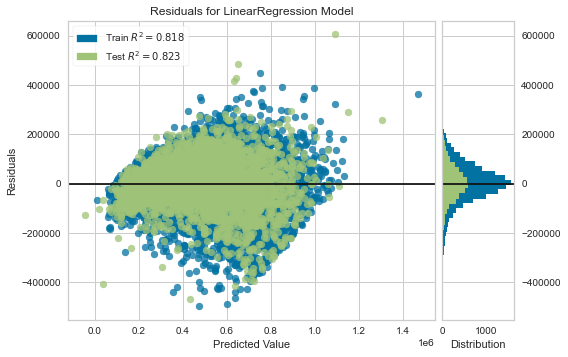

NameError: name 'fig' is not defined

In [76]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()
fig.savefig('./images/ResidualsPlotforLinearRegressionModel7b.jpg',
            transparent = False,bbox_inches="tight");

In [ ]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r')
fig.savefig('./images/QQPlotModel7b.jpg',
            transparent = False,bbox_inches="tight");;

In [ ]:
y = y_train
x = X_train.filter(cols, axis=1)
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

So far, model 7b seems to be preforming the best. After experimenting with the features with little improvement, this may be our best option. However, the Condition Number is fairly high, which conflicts with the Assumption regarding Multicollinearity. Given our dataset features, this may be unavoidable. Let's try one more.

#### Model 8

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'waterfront' and the columns created from encoding 'bedroom_bin', 'condition', 'view', and 'zipcode'.

In [ ]:
cols2 = ['sqft_living', 'sqft_living15','bathrooms', 'yr_built'] + encoded_bedroom_bin + encoded_condition+ encoded_zipcode
y = y_train
x = X_train.filter(cols2, axis=1)

y2 = y_test
x2 = X_test.filter(cols2, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

In [ ]:
lr = LinearRegression()

visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

In [ ]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

In [ ]:
y = y_train
x = X_train.filter(cols, axis=1)
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

Model 8 seems to be performing about the same as model 7b. We will have to take into account how interpretable and how important some of these features are when deciding which model we want to use.

This OLS summary denotes: 

## Deployment


This section of the notebook will focus on how we used our data and the predictive power of our model to build actionable recommendation for our stakeholder: Keller Willaims Realty. 

We first wanted to extrapolate 3 questions, from our main business question, that we can answer using our data and our final model. The three questions we arrived at is:
 1. Which zipcodes have the most number of houses sold?
 2. What features are in-demand?
 3. What price range are the most in-demand houses in?

### Which zipcodes have the most number of houses sold?


In [ ]:
df['zipcode'].value_counts()

We could answer this question relatively easily by using the .value_counts() method in the pandas library. We further visualized this using Folium. To do so we will be using geoJSON file sourced from [gis-kingcounty.opendata](https://gis-kingcounty.opendata.arcgis.com/datasets/zipcodes-for-king-county-and-surrounding-area-shorelines-zipcode-shore-area/explore). 
As it stands, the geoJSON file includes zipcodes where no sales were recorded. For a cleaner visual we will pare this file down to only include zipcodes in our dataframe. We shall open the geojson and create a brand new geojson with the appropriate zips.

In [ ]:
import geojson
from geojson import FeatureCollection, dump
import json

with open('data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.geojson', 'r') as f:
    geoJSON_raw = json.load(f)

# Extracting list of zipcodes from above file that exist in our dataset
features = []
for f in geoJSON_raw['features']:
    if (int(f['properties']['ZIP']) in df['zipcode'].unique()):
        features.append(f)

with open('data/Updated_King_County_Zipcodes.geojson', 'w') as f:
    dump(FeatureCollection(features), f)

In [ ]:
# Loading our updated geoJSON file
zip_geo = f"data/Updated_King_County_Zipcodes.geojson"

# Creating a dataframe for folium. Grabbing zipcode column and running a count on it
zipcode_choro_data = pd.DataFrame(df.zipcode)
zipcode_choro_data['House_Listing_Count'] = 0
zipcode_choro_data = zipcode_choro_data.groupby(
    'zipcode').count().reset_index()

# Initializing folium map
zipcodes_indemand_map = folium.Map(KC_coord, zoom_start=9)


# Map Details
folium.Choropleth(
    geo_data=zip_geo,
    name="choropleth",
    data=zipcode_choro_data,
    columns=["zipcode", "House_Listing_Count"],
    key_on="feature.properties.ZIP",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.33,
    legend_name="House Sales",
    highlight=True,
).add_to(zipcodes_indemand_map)

# Adding Layer Control and a few different tilesets.
# Map defaults to OpenStreetMap
folium.TileLayer('OpenStreetMap').add_to(zipcodes_indemand_map)
folium.TileLayer('cartodbdark_matter').add_to(zipcodes_indemand_map)
folium.TileLayer('cartodbpositron').add_to(zipcodes_indemand_map)
folium.TileLayer('stamentoner').add_to(zipcodes_indemand_map)
folium.TileLayer('stamenterrain').add_to(zipcodes_indemand_map)
folium.TileLayer('Stamen Watercolor').add_to(zipcodes_indemand_map)
folium.LayerControl().add_to(zipcodes_indemand_map)

zipcodes_indemand_map.fit_bounds(zipcodes_indemand_map.get_bounds())
zipcodes_indemand_map.save('data/choropeth_zip_salecounts.html')

zipcodes_indemand_map

The city of Seattle and surrounding areas, especially the areas surrounding Green Lake, immediately stand out with over 500 listings in the year. 

Lets also have a quick look at how the different listings are spread across King County in terms of price. We'll break the entire price range down into pentiles.

In the following cell, we'll create a column to categorize each property in a price percentile bracket, but more specifically, a color associated with it.
To see the colors selected visit [Click Here](https://davidmathlogic.com/colorblind/#%23FFFFA3-%23B9FFBB-%23838af6-%238F40AB-%23D44747)


In [ ]:
df['price_color'] = pd.qcut(df['price'],
                            q=[0, .2, .4, .6, .8, 1],
                            labels=['#FFFFA3',
                                    '#B9FFBB',
                                    '#838AF6',
                                    '#8F40AB',
                                    '#D44747',
                                    ])

**Note:** the following map creation cell may take a while to load. The cell when ran will create an HTML file as well as display in the notebook. To avoid waiting, you can visit a pre-generated version [here](maps/PropertiesPentileDisplay.html).

In [ ]:
# Note: This cell may take a little while to run
# Initializing Folium map
GreenLake_coord = (47.6802,-122.3284)
propertiesInPentiles_map = folium.Map(location = GreenLake_coord, tiles = 'cartodbdark_matter', zoom_start = 13)

for property in df.iterrows():
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your m'''
    folium.Circle(location=[property[1].lat,property[1].long],
                  radius=1,
                  fill=True,
                  color = property[1].price_color,
                  weight= 2,
                  opacity=0.8,
                 ).add_to(propertiesInPentiles_map)
    
# Adding legend to map
# Encoding png in base 64 allows image to be embedded in the html file as well
import base64
from folium.plugins import FloatImage

with open('images/Legendforpricemap.png', 'rb') as lf:
  # open in binary mode, read bytes, encode, decode obtained bytes as utf-8 string
  b64_content = base64.b64encode(lf.read()).decode('utf-8')

FloatImage('data:image/png;base64,{}'.format(b64_content), bottom=2, left=2).add_to(propertiesInPentiles_map)


#Save the map to an HTML file
propertiesInPentiles_map.save('maps/PropertiesPentileDisplay.html')

propertiesInPentiles_map

Not only are the areas around Green Lake in high demand, but the property values are high as well with plenty of listings appearing in the top pentile bracket of overall King County sales. Lets compare the median prices for zipcodes around Green Lake to KC.

In [ ]:
GL_medianprice = df.loc[df.zipcode.isin([98103,98117,98107,98115,98105,98195])].price.median()
KC_medianprice = df.price.median()
print(f'Median Price in areas around Green Lake: {GL_medianprice}\nMedian Price across King County:{KC_medianprice}')

The demand for these zipcodes are high, so potential future revenue can be optimized by focusing on these areas.

### What features are in-demand?

We again employed the use of the .value_counts() method in the pandas library to determine which type of 'view', 'bedroom/bathroom' ratio, 'condition' and 'yr_built' were the most popular/in-demand.

In [ ]:
df.view.value_counts()

In [ ]:
(df.bedrooms/df.bathrooms).value_counts()

In [ ]:
df.price.value_counts()

In [ ]:
df.condition.value_counts()

In [ ]:
df.bedrooms.value_counts()

In [ ]:
df.bathrooms.value_counts()

In [ ]:
df.yr_built.value_counts()

### What price range are the most in-demand houses in?

To answer this question, we created a data frame called X_potentials that included corresponding values from the answers to the questions above. The goal of this is to determine a price range that these houses with in-demand features and located in popular zipcodes, will ultimately sell for. 

In [ ]:
X_potentials = pd.DataFrame(columns = X_train.columns)

In [ ]:
for num in range(0,1):
    X_potentials = X_potentials.append(
    pd.Series(0, index=X_potentials.columns), 
    ignore_index=True)

In [ ]:
X_potentials['sqft_living'].replace(0,df['sqft_living'].median(),inplace=True)
X_potentials['sqft_living15'].replace(0,df['sqft_living15'].median(),inplace=True)
X_potentials['bathrooms'].replace(0,df.bathrooms.value_counts().index[0],inplace=True)
X_potentials['yr_built'].replace(0,df.yr_built.value_counts().index[0],inplace=True)

X_potentials['bedrooms_bin_x0_3BR'].replace(0,1,inplace=True)

# condition not needed. By default 'Average'

X_potentials['zipcode_x0_98103'].replace(0,1,inplace=True)

In [ ]:
X_potentials[cols]

In [ ]:
lr.fit(X_train.filter(cols, axis=1),y_train)

In [ ]:
final_pred = lr.predict(X_potentials[cols])[0]

It is important to note that the columns that were created during the encoding process will have zero values for all columns except for the columns that contain the most valued features and zipcodes.

In [ ]:
(final_pred - 43000,final_pred +43000)

The price range that are model is predicting is between 610,306 and 696,306 dollars. The value we used to achieve this range is the RMSE value for our final model.

In [ ]:
# Visualization
vis_data = y_test.to_frame()
vis_data['prediction'] = test_preds
vis_data.sort_values(by='price', ascending=False)[925:930]
y = np.arange(5)
h = 0.6

fig, ax = plt.subplots(figsize=(10,10))


ax.set_title(f'Price vs Predictions')
ax.set_ylabel('Price')
ax.get_xaxis().set_visible(False)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.bar(y-h/3, vis_data.sort_values(by='price', ascending=False)[925:930]['price'], h/1.5, color='navy')
ax.bar(y+h/3, vis_data.sort_values(by='price', ascending=False)[925:930]['prediction'], h/1.5, color='orange')

ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)

ax.legend(['Actual Price', 'Predicted Price']);
ax.grid(False)

fig.savefig('./images/price_vs_preds.jpg',
            transparent = False,bbox_inches="tight");

The graph demonstrates how close some of our model's predictions have been getting. 

### Recommendations and Conclusions


In conclusion, the answers to the questions above translates into actionable recommendations. The zip codes which have sold the most homes are the zip codes we recommend targeting in terms of sellers. Similarly with the features of the home, such as bedroom etc. We recommend targeting sellers that have these features in their homes. We recommend using our model to input these values to predict what price the house will ultimately sell for, thereby also predicting future potential revenue. 

## Next steps

For Next Steps, if we gather more first-party data we can analyze the potential costs of our recommended strategy and provide a more holistic overview of our current model. With more historical data we can upgrade our model to include time series analysis which will formulate more accurate predictions and also illustrate both sales and price trends throughout the year, which would be invaluable to Keller Williams Realty moving forward. Furthermore, we can use the upgraded model to determine whether the housing market is over or under-inflated at any given time. This would be a great predictive tool in understanding whether to gear marketing efforts to sellers or buyers and vice versa. 